In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='7'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=8,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=4,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split4-mask/",
    project_name="breakfast-split-4",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 8, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 4, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split4-mask/', 'project_name': 'breakfast-split-4', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split4.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split4.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_sp

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1136
Number of videos not found in train fold is 0
Number of videos logged in test fold is 576
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
df=pd.read_csv(config.label_id_csv)
label_id_to_label_name = {}
label_name_to_label_id_dict = {}
for i, ele in df.iterrows():
    label_id_to_label_name[ele.label_id] = ele.label_name
    label_name_to_label_id_dict[ele.label_name] = ele.label_id

In [10]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [11]:
# selected_frames_dict = pickle.load(open("data/breakfast_len_assum_annotations.pkl", 'rb'))
# loaded_vidid_selected_frames
boundary_frames_dict = pickle.load(open("data/breakfast_boundary_annotations.pkl", "rb"))
# video_id_boundary_frames
selected_frames_dict = None

In [12]:
loaded_mean_var_actions = pickle.load(open("data/breakfast_meanvar_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class):
    mean_class, std_class = loaded_mean_var_actions[label_id_to_label_name[cur_class]]
    mean_class = mean_class
    prob = cur_len * torch.log(torch.tensor(mean_class, device=device) + 1e-5)
    prob = prob - mean_class
    factorials = torch.cumsum(torch.log(torch.arange(1, torch.max(cur_len)+1, 1).type(torch.float).to(device)), 
                              dim=0)[min(cur_len)-1:]
    prob = prob - factorials
    return prob

# get_possion_prob(torch.arange(10, 21), 20)

In [13]:
prob_video_each_segment_dict = {}

In [14]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):

        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[i]
        label_next_ele = labels[i + 1]

        indices = torch.arange(cur_ele, next_ele).to(cumsum_feat.device)
        strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
        end_index = cumsum_feat[next_ele - 1, :][None, :]
        left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
        right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]

        cur_boundary_len = indices - cur_boundary
        len_prob = get_possion_prob(cur_boundary_len, label_cur_ele)

        prob = torch.softmax((left_sum + right_sum + len_prob), dim=0)
#         prob = torch.softmax((left_sum + right_sum), dim=0)

        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob.detach().cpu().numpy()).item())
        prob_each_segment.append(prob)
    
    return prob_each_segment

In [15]:
def calculate_element_probb(data_feat, data_count, video_ids): #, loaded_vidid_selected_frames, boundaries_dict):
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        
        selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]
        prob_video = prob_vals_per_segment(selected_frames_indices, cur_vid_feat, selected_frames_labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [16]:
def get_estimated_loss(data_feat, data_count, video_ids): #, loaded_vidid_selected_frames, boundaries_dict):
#     global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        
        selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]

        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames_indices[0]
        if start_ele_idx > 0:
            start_ele_label_idx = selected_frames_labels[0]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob.unsqueeze(0))
        
        for i, cur_ele in enumerate(selected_frames_indices[:-1]):
            next_ele = selected_frames_indices[i + 1]
            label_cur_ele = selected_frames_labels[i]
            label_next_ele = selected_frames_labels[i + 1]

            indices = torch.arange(cur_ele, next_ele)
            strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
            end_index = cumsum_feat[next_ele - 1, :][None, :]
            left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
            right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]
            current_vid_prob_arr.append((left_sum + right_sum)  * (prob_each_video[i]))
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = selected_frames_labels[-1]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames_indices[-1] - 1, \
                                                                         :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob.unsqueeze(0))
            
        loss_arr.append(torch.cat(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [17]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_estimated_boundaries():
    estimated_boundary_dict = {}
    for video_id in train_split_file_list:
        ele = video_id.split(".txt")[0]
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        
        selected_frames_indices_and_labels = selected_frames_dict[video_id]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_frames_indices[i], selected_frames_indices[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_frames_indices[i]) or (estimated_boundary > selected_frames_indices[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [18]:
def get_boundary_err():
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for video_id in train_split_file_list:
        ele = video_id.split(".txt")[0]
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(boundary_frames_dict[video_id][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = boundary_frames_dict[video_id][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")

In [19]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [20]:
loaded_file=torch.load("/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split4-slup15/ms-tcn-initial-25-epochs.wt")
model.load_state_dict(loaded_file)

<All keys matched successfully>

In [21]:
pseudo_labels_dir = "/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/length_segmentation_output/"
def get_single_random(output_p, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((output_p.shape[0], output_p.shape[2]), dtype=torch.long, 
                                        device=output_p.device) * (-100)
    for iter_num, cur_vidid in enumerate(video_ids):
        pseudo_l = open(pseudo_labels_dir + cur_vidid + ".txt").read().split("\n")[0:-1]
        pseudo_l = [label_name_to_label_id_dict[ele] for ele in pseudo_l]
        abc = torch.tensor(pseudo_l).to(torch.long).to(boundary_target_tensor.device)
        frame_idx_tensor = torch.arange(0, len(pseudo_l), 1).to(device)
        boundary_target_tensor[iter_num, frame_idx_tensor] = abc

    return boundary_target_tensor

In [22]:
weakly_labels = pickle.load(open("data/breakfast_weaklysupervised_labels.pkl", "rb"))

In [23]:
prior_probs = pickle.load(open('data/breakfast_lengthmodel_multinomial_prior.pkl', 'rb'))

In [33]:
def get_boundary(labels_arr):
    unique_ids = []

    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            unique_ids.append(i - 1)
            start = i
        prev_ele = ele

    unique_ids.append(len(labels_arr) - 1)
    return unique_ids

def get_boundary_from_pseudo_data(psuedo_dir):
    boundary_dict = {}
    for filename in glob.glob(psuedo_dir + "/*.txt"):
        video_id = filename.split("/")[-1]
        data = open(filename).read().split("\n")[0:-1]
        data = np.array(data)
        boundary = get_boundary(data)
        boundary_dict[video_id.split(".txt")[0]] = boundary
    return boundary_dict


In [35]:
import copy
def change_selected_frames(model):
    global selected_frames_dict
    new_selected_frame_dict = {}
    if selected_frames_dict is None:
        estimated_boundary_dict = get_boundary_from_pseudo_data(pseudo_labels_dir)
    else:
        estimated_boundary_dict = get_estimated_boundaries()
    with torch.no_grad():
        for train_idx, item in enumerate(trainloader):
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
            if train_idx % 10 == 0:
                print(f"Completed {train_idx} videos selected frames calculation")
            middle_pred, predictions = model(item_0, src_mask_mse)

            for idx, video_id in enumerate(item[4]):
                start = 0
                new_index_label_pair_list = []
                weakly_labels_video = [label_name_to_label_id_dict[wl] for wl in weakly_labels[video_id + ".txt"]]
                cur_video_predictions = predictions[-1][idx][:, :item_1[idx]]
                cur_preds_for_weakly_labels = torch.softmax(cur_video_predictions[weakly_labels_video], dim=0)
                
                estimated_boundary = estimated_boundary_dict[video_id]
                estimated_boundary.append(item[1][idx].item())
                start_mark = 0
                for i, prob_class in enumerate(cur_preds_for_weakly_labels):
                    expected_value_of_class = torch.argmax(prob_class[start_mark: estimated_boundary[i] + 1]).item() \
                                                + start_mark

                    if i > 0 and expected_value_of_class <= new_index_label_pair_list[-1][0]:
                        print(f"start_mark = {start_mark}, Boundary End = {estimated_boundary[i] + 1}"+
                             f"Expected argmax = {expected_value_of_class}")
                        print(new_index_label_pair_list)
                        print(i)
                        print(estimated_boundary)
                        import pdb
                        pdb.set_trace()
                    new_index_label_pair_list.append((expected_value_of_class,
                                                      label_id_to_label_name[weakly_labels_video[i]]))
                    start_mark = expected_value_of_class + 1

                    
#                 final_list = new_index_label_pair_list
#                 is_valid_list = True
#                 for i in range(1, len(final_list) - 1, 1):
#                     cur_ele = final_list[i]
                    
#                     if not (final_list[i - 1][0] < cur_ele[0] and cur_ele[0] < final_list[i + 1][0]):
#                         is_valid_list  = False

#                 if is_valid_list == False:
#                     print(f"Could not find expected solution for video {video_id}")
#                     print(final_list)
#                     import pdb
#                     pdb.set_trace()
                
                new_selected_frame_dict[video_id + ".txt"] = new_index_label_pair_list
                
        return new_selected_frame_dict

In [26]:
def get_new_selected_frame_acc(selected_frame_dict):
    correct = 0.0
    total = 0.0

    for video_id in selected_frame_dict.keys():
        ground_labels = open(config.ground_truth_files_dir + video_id).read().split("\n")[0:-1]
        ground_labels = np.array(ground_labels)

        selected_frames_index = [ele[0] for ele in selected_frame_dict[video_id]]
        selected_frames_labels = np.array([ele[1] for ele in selected_frame_dict[video_id]])

        ground_selected_labels = ground_labels[selected_frames_index]

        correct += np.sum(ground_selected_labels == selected_frames_labels)
        total += len(ground_selected_labels)

    print("Total correct pivots labels selected = ", correct * 100.0 / total)


In [36]:
# selected_frames_dict = None
selected_frames_dict = change_selected_frames(model)
get_new_selected_frame_acc(selected_frames_dict)

Completed 0 videos selected frames calculation
Completed 10 videos selected frames calculation
Completed 20 videos selected frames calculation
Completed 30 videos selected frames calculation
Completed 40 videos selected frames calculation
Completed 50 videos selected frames calculation
Completed 60 videos selected frames calculation
Completed 70 videos selected frames calculation
Completed 80 videos selected frames calculation
Completed 90 videos selected frames calculation
Completed 100 videos selected frames calculation
Completed 110 videos selected frames calculation
Completed 120 videos selected frames calculation
Completed 130 videos selected frames calculation
Completed 140 videos selected frames calculation
Total correct pivots labels selected =  59.87798546209761


In [37]:
# Initialize Expection Boundaries
print("Calculating Expectation")
correct = 0.0
total = 0.0
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4])

        if i % 10 == 0:
            print(f"Completed iter {i}")

get_boundary_err()

Calculating Expectation
Completed iter 0
Completed iter 10
Completed iter 20
Completed iter 30
Completed iter 40
Completed iter 50
Completed iter 60
Completed iter 70
Completed iter 80
Completed iter 90
Completed iter 100
Completed iter 110
Completed iter 120
Completed iter 130
Completed iter 140
Train Boundary avergage error = 318.826
Train From boundary avergage accuracy = 59.286


In [38]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split4-mask/'

In [39]:
initialize_epoch = 25
expectation_cal_gap = 5
best_val_acc = 0

for epoch in range(51, 150):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        psuedo_l = get_single_random(predictions[-1], item[4])
        
        loss = 0
        for p in predictions:
            if epoch <= initialize_epoch:
                loss += ce_criterion(p, psuedo_l)
                loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), 
                                                                    F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                                            max=16) * src_mask_mse[:, :, 1:])
            else:
                prob = torch.softmax(p, dim=1)
                prob = prob.permute(0, 2, 1)
                es_loss, _ = get_estimated_loss(prob, item_1, item[4])
                loss += es_loss
            

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")

    # Calculating Expectation Step
    model.eval()
    
    print("Calculating Validation Data Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

            middle_pred, predictions = model(item_0, src_mask_mse)

            pred = torch.argmax(predictions[-1], dim=1)
            correct += float(torch.sum((pred == item_2) * src_mask).item())
            total += float(torch.sum(src_mask).item())

    val_acc = correct * 100.0 / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-best-model.wt")
    torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-last-model.wt")
    print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

#     if (epoch == initialize_epoch) or ((epoch > initialize_epoch) and ((epoch % (3 * expectation_cal_gap)) == 0)):
    if ((epoch >= 50) and ((epoch % 25) == 0)):
        print("Updating selected frames again")
        torch.save(model.state_dict(), config.output_dir + f"ms-tcn-initial-{initialize_epoch}-epochs.wt")
        selected_frames_dict = change_selected_frames(model)
        get_new_selected_frame_acc(selected_frames_dict)

#     if (epoch == initialize_epoch) or ((epoch > initialize_epoch) and (epoch % expectation_cal_gap == 0)):
    if ((epoch > initialize_epoch) and (epoch % expectation_cal_gap == 0)):
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0

        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                middle_pred, predictions = model(item_0, src_mask_mse)
                prob = torch.softmax(predictions[-1], dim=1)
                prob = prob.permute(0, 2, 1)
                calculate_element_probb(prob, item_1, item[4])
                
                if i % 10 == 0:
                    print(f"Epoch {epoch} iter {i}")
                    
        get_boundary_err()



Starting Training
Training:: Epoch 51, Iteration 0, Current loss 0.20132208917337674 Accuracy 64.17264668636555
Training:: Epoch 51, Iteration 10, Current loss 0.16835234046968886 Accuracy 71.3464696223317
Training:: Epoch 51, Iteration 20, Current loss 0.13501314295253475 Accuracy 66.27936833996662
Training:: Epoch 51, Iteration 30, Current loss 0.19811861743351156 Accuracy 63.06688590675224
Training:: Epoch 51, Iteration 40, Current loss 0.17685379121323452 Accuracy 54.757608564898355
Training:: Epoch 51, Iteration 50, Current loss 0.221481684156214 Accuracy 57.2808873134755
Training:: Epoch 51, Iteration 60, Current loss 0.15532265828806754 Accuracy 42.025256135334764
Training:: Epoch 51, Iteration 70, Current loss 0.18350749676200984 Accuracy 52.77996672795727
Training:: Epoch 51, Iteration 80, Current loss 0.19075508829768117 Accuracy 64.7767447950766
Training:: Epoch 51, Iteration 90, Current loss 0.2554912620093353 Accuracy 71.10115911485775
Training:: Epoch 51, Iteration 100, C

Training:: Epoch 56, Iteration 20, Current loss 0.24514163215728507 Accuracy 68.41459896133873
Training:: Epoch 56, Iteration 30, Current loss 0.22760726998949973 Accuracy 77.65601217656013
Training:: Epoch 56, Iteration 40, Current loss 0.2576266864261182 Accuracy 64.96854570124583
Training:: Epoch 56, Iteration 50, Current loss 0.32396806616261037 Accuracy 58.65990202939118
Training:: Epoch 56, Iteration 60, Current loss 0.21739642459826458 Accuracy 59.793773389601085
Training:: Epoch 56, Iteration 70, Current loss 0.2684853983340162 Accuracy 54.462545252018934
Training:: Epoch 56, Iteration 80, Current loss 0.32141128980075273 Accuracy 53.982300884955755
Training:: Epoch 56, Iteration 90, Current loss 0.253619353503009 Accuracy 59.65603255875016
Training:: Epoch 56, Iteration 100, Current loss 0.2811655497741822 Accuracy 46.63608562691132
Training:: Epoch 56, Iteration 110, Current loss 0.27387394941275434 Accuracy 58.01182954698212
Training:: Epoch 56, Iteration 120, Current loss 0

Training:: Epoch 61, Iteration 40, Current loss 0.14480445762824937 Accuracy 57.72899391266836
Training:: Epoch 61, Iteration 50, Current loss 0.16510900217190028 Accuracy 63.69148014769567
Training:: Epoch 61, Iteration 60, Current loss 0.24930951248298494 Accuracy 68.08567129834499
Training:: Epoch 61, Iteration 70, Current loss 0.2132011261448976 Accuracy 64.54358850519198
Training:: Epoch 61, Iteration 80, Current loss 0.17562375871745384 Accuracy 64.56316553727008
Training:: Epoch 61, Iteration 90, Current loss 0.15132427757263217 Accuracy 71.55322862129145
Training:: Epoch 61, Iteration 100, Current loss 0.1775358247852901 Accuracy 52.43264977885002
Training:: Epoch 61, Iteration 110, Current loss 0.16363076944714589 Accuracy 68.73867254469752
Training:: Epoch 61, Iteration 120, Current loss 0.21937233784114418 Accuracy 64.46538652306384
Training:: Epoch 61, Iteration 130, Current loss 0.22583219765847032 Accuracy 56.430118820980766
Training:: Epoch 61, Iteration 140, Current los

Training:: Epoch 66, Iteration 60, Current loss 0.2198314861545952 Accuracy 70.16827430824473
Training:: Epoch 66, Iteration 70, Current loss 0.12581222112255816 Accuracy 73.05119390504507
Training:: Epoch 66, Iteration 80, Current loss 0.16846204077063198 Accuracy 47.498459642637094
Training:: Epoch 66, Iteration 90, Current loss 0.16464768292650914 Accuracy 48.969531946856954
Training:: Epoch 66, Iteration 100, Current loss 0.14951377137802585 Accuracy 67.3841059602649
Training:: Epoch 66, Iteration 110, Current loss 0.19644152983962643 Accuracy 64.06907433380084
Training:: Epoch 66, Iteration 120, Current loss 0.16998052747595302 Accuracy 65.82950484941297
Training:: Epoch 66, Iteration 130, Current loss 0.16177849373953646 Accuracy 62.88073950598576
Training:: Epoch 66, Iteration 140, Current loss 0.20031418032189996 Accuracy 62.73473208877141
Calculating Validation Data Accuracy
Validation:: Epoch 66, Probability Accuracy 53.15279838430317
Starting Training
Training:: Epoch 67, It

Training:: Epoch 72, Iteration 10, Current loss 0.21450133937123972 Accuracy 53.257742426806566
Training:: Epoch 72, Iteration 20, Current loss 0.19332485831697732 Accuracy 74.91839970157605
Training:: Epoch 72, Iteration 30, Current loss 0.2501706383147574 Accuracy 65.93738211995473
Training:: Epoch 72, Iteration 40, Current loss 0.1758950879674831 Accuracy 75.71023709131126
Training:: Epoch 72, Iteration 50, Current loss 0.23394296167091902 Accuracy 60.65322956163108
Training:: Epoch 72, Iteration 60, Current loss 0.18472010089671623 Accuracy 68.36378157132874
Training:: Epoch 72, Iteration 70, Current loss 0.23201504702510622 Accuracy 58.54465958775765
Training:: Epoch 72, Iteration 80, Current loss 0.14485211540527693 Accuracy 67.07665713715843
Training:: Epoch 72, Iteration 90, Current loss 0.4023866719924161 Accuracy 66.80802940344925
Training:: Epoch 72, Iteration 100, Current loss 0.24730055921463517 Accuracy 70.539665763921
Training:: Epoch 72, Iteration 110, Current loss 0.17

Training:: Epoch 76, Iteration 100, Current loss 0.35764903017178407 Accuracy 57.76330076004343
Training:: Epoch 76, Iteration 110, Current loss 0.3794340483726252 Accuracy 64.14564037048866
Training:: Epoch 76, Iteration 120, Current loss 0.3413372008320948 Accuracy 65.38627535606388
Training:: Epoch 76, Iteration 130, Current loss 0.5032225495716256 Accuracy 63.567509541984734
Training:: Epoch 76, Iteration 140, Current loss 1.1558341627891273 Accuracy 63.209969315548875
Calculating Validation Data Accuracy
Validation:: Epoch 76, Probability Accuracy 53.021016477231875
Starting Training
Training:: Epoch 77, Iteration 0, Current loss 0.4185387465512861 Accuracy 64.91091076879393
Training:: Epoch 77, Iteration 10, Current loss 1.2022888462206394 Accuracy 62.95934562324503
Training:: Epoch 77, Iteration 20, Current loss 1.3037886143522959 Accuracy 56.96468053744543
Training:: Epoch 77, Iteration 30, Current loss 1.2268454498812136 Accuracy 55.93258511317143
Training:: Epoch 77, Iteratio

Training:: Epoch 81, Iteration 120, Current loss 0.24413584170293218 Accuracy 61.428430502120946
Training:: Epoch 81, Iteration 130, Current loss 0.2694643059926607 Accuracy 59.90237481489607
Training:: Epoch 81, Iteration 140, Current loss 0.22108786559789462 Accuracy 65.30034202650705
Calculating Validation Data Accuracy
Validation:: Epoch 81, Probability Accuracy 53.70084118196851
Starting Training
Training:: Epoch 82, Iteration 0, Current loss 0.202968861238209 Accuracy 64.4291754756871
Training:: Epoch 82, Iteration 10, Current loss 0.2409116722939252 Accuracy 61.85760715011172
Training:: Epoch 82, Iteration 20, Current loss 0.21258282029625122 Accuracy 55.05564764385508
Training:: Epoch 82, Iteration 30, Current loss 0.2533055230951041 Accuracy 72.15794158103407
Training:: Epoch 82, Iteration 40, Current loss 0.20820322167315866 Accuracy 70.66518963971093
Training:: Epoch 82, Iteration 50, Current loss 0.23836944508866353 Accuracy 65.18968435726377
Training:: Epoch 82, Iteration 

Training:: Epoch 86, Iteration 140, Current loss 0.18023752694869152 Accuracy 72.51580483060464
Calculating Validation Data Accuracy
Validation:: Epoch 86, Probability Accuracy 54.157543513356295
Starting Training
Training:: Epoch 87, Iteration 0, Current loss 0.17397687205861795 Accuracy 67.3913043478261
Training:: Epoch 87, Iteration 10, Current loss 0.14327526841446703 Accuracy 58.61216884063842
Training:: Epoch 87, Iteration 20, Current loss 0.2024566446705037 Accuracy 59.85909291061206
Training:: Epoch 87, Iteration 30, Current loss 0.27198579290917513 Accuracy 62.174111907302944
Training:: Epoch 87, Iteration 40, Current loss 0.23245618744252408 Accuracy 54.13160924630237
Training:: Epoch 87, Iteration 50, Current loss 0.151803938468427 Accuracy 66.37579436593
Training:: Epoch 87, Iteration 60, Current loss 0.15358527162601465 Accuracy 70.63960955561264
Training:: Epoch 87, Iteration 70, Current loss 0.15309585319377433 Accuracy 59.40332759609868
Training:: Epoch 87, Iteration 80

Validation:: Epoch 91, Probability Accuracy 53.298469271040986
Starting Training
Training:: Epoch 92, Iteration 0, Current loss 0.19350778045810252 Accuracy 67.94411787159325
Training:: Epoch 92, Iteration 10, Current loss 0.21471346012765344 Accuracy 66.48489932885906
Training:: Epoch 92, Iteration 20, Current loss 0.21357304717075737 Accuracy 71.02476794626615
Training:: Epoch 92, Iteration 30, Current loss 0.1582918595641861 Accuracy 61.280463602445025
Training:: Epoch 92, Iteration 40, Current loss 0.2624518906872801 Accuracy 62.02275600505689
Training:: Epoch 92, Iteration 50, Current loss 0.20529997183103066 Accuracy 62.06409464112298
Training:: Epoch 92, Iteration 60, Current loss 0.1995395874201198 Accuracy 63.54009077155825
Training:: Epoch 92, Iteration 70, Current loss 0.2628573603932565 Accuracy 62.80323450134771
Training:: Epoch 92, Iteration 80, Current loss 0.2503445267081077 Accuracy 53.31262240832039
Training:: Epoch 92, Iteration 90, Current loss 0.2238859756314683 Ac

Training:: Epoch 97, Iteration 30, Current loss 0.18317081518265327 Accuracy 59.50382391344898
Training:: Epoch 97, Iteration 40, Current loss 0.2269698628862235 Accuracy 60.48934375114633
Training:: Epoch 97, Iteration 50, Current loss 0.26265586119777284 Accuracy 54.52111838191553
Training:: Epoch 97, Iteration 60, Current loss 0.21812009960525502 Accuracy 61.12614135948596
Training:: Epoch 97, Iteration 70, Current loss 0.21744626257033617 Accuracy 59.33536455750018
Training:: Epoch 97, Iteration 80, Current loss 0.2500738883966059 Accuracy 69.7063127090301
Training:: Epoch 97, Iteration 90, Current loss 0.20520287750323588 Accuracy 62.689379663827545
Training:: Epoch 97, Iteration 100, Current loss 0.18169186762181444 Accuracy 73.20815859702631
Training:: Epoch 97, Iteration 110, Current loss 0.20458266875985764 Accuracy 72.7992324298393
Training:: Epoch 97, Iteration 120, Current loss 0.1808016877663775 Accuracy 60.707498903669055
Training:: Epoch 97, Iteration 130, Current loss 0

Training:: Epoch 101, Iteration 120, Current loss 0.4543242220963586 Accuracy 57.99487742407611
Training:: Epoch 101, Iteration 130, Current loss 0.2875196558832485 Accuracy 70.09080142123963
Training:: Epoch 101, Iteration 140, Current loss 0.3062289078044711 Accuracy 64.74727052163364
Calculating Validation Data Accuracy
Validation:: Epoch 101, Probability Accuracy 53.15549448035608
Starting Training
Training:: Epoch 102, Iteration 0, Current loss 0.33681782799152216 Accuracy 66.38193306810203
Training:: Epoch 102, Iteration 10, Current loss 0.2846907300651552 Accuracy 68.00924588269287
Training:: Epoch 102, Iteration 20, Current loss 0.14104340678249322 Accuracy 76.12046738713039
Training:: Epoch 102, Iteration 30, Current loss 0.26587258374924005 Accuracy 58.867269797992314
Training:: Epoch 102, Iteration 40, Current loss 0.26231580928988146 Accuracy 61.816712134990404
Training:: Epoch 102, Iteration 50, Current loss 0.2066509457751134 Accuracy 64.49082776949504
Training:: Epoch 10

Training:: Epoch 106, Iteration 130, Current loss 0.29203159116957544 Accuracy 51.04246565790391
Training:: Epoch 106, Iteration 140, Current loss 0.19975656144452353 Accuracy 70.98880597014926
Calculating Validation Data Accuracy
Validation:: Epoch 106, Probability Accuracy 52.955493173158
Starting Training
Training:: Epoch 107, Iteration 0, Current loss 0.1503849475556011 Accuracy 68.27178126912875
Training:: Epoch 107, Iteration 10, Current loss 0.21517666603221122 Accuracy 68.00361200993302
Training:: Epoch 107, Iteration 20, Current loss 0.163077859995727 Accuracy 56.65578278054649
Training:: Epoch 107, Iteration 30, Current loss 0.18223720863385462 Accuracy 69.84533636967454
Training:: Epoch 107, Iteration 40, Current loss 0.13758792104781858 Accuracy 61.43013793501472
Training:: Epoch 107, Iteration 50, Current loss 0.23530087796683502 Accuracy 69.35271530444322
Training:: Epoch 107, Iteration 60, Current loss 0.13559609715940976 Accuracy 71.33445472385759
Training:: Epoch 107, 

KeyboardInterrupt: 

In [31]:
estimated_boundary_dict

NameError: name 'estimated_boundary_dict' is not defined

In [32]:
print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

Validation:: Epoch 130, Probability Accuracy 51.43919338691232


In [ ]:
53.5

In [33]:
best_val_acc

54.61000906173455

In [24]:
torch.save(model.state_dict(),
"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-speed/final-em-maximized.wt")

In [24]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split1/'

In [34]:
model.load_state_dict(torch.load(config.output_dir + "ms-tcn-emmax-best-model.wt"))
# model.load_state_dict(torch.load(config.output_dir + "ms-tcn-initial-15-epochs.wt"))

<All keys matched successfully>

In [35]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Probability Accuracy 54.625639564561894


In [36]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4])

        if i % 10 == 0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
161 iteration done
171 iteration done
181 iteration done
Train Boundary avergage error = 307.224
Train From boundary avergage accuracy = 57.704


In [26]:
with torch.no_grad():
    idx = 1

    cur_vid_feat = torch.softmax(predictions[-1], dim=1).permute(0, 2, 1)[idx]
    cur_vidid = item[4][idx]

    selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
    selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
    selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]
    
    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
    prob_each_segment = prob_vals_per_segment(selected_frames_indices, cur_vid_feat, selected_frames_labels)


In [27]:
selected_frames_indices

[64, 228, 481, 735, 1578, 2388, 2567, 2745]

In [28]:
boundary_frames_dict[cur_vidid + ".txt"]

[88, 229, 578, 1128, 2241, 2479, 2720, 2810]

Min prob 0 = 0.0
Min prob 1 = 0.0
Min prob 2 = 0.0
Min prob 3 = 0.0
Min prob 4 = 0.0
Min prob 5 = 7.224189870987231e-126
Min prob 6 = 4.631831900603335e-244


(0, 2811)

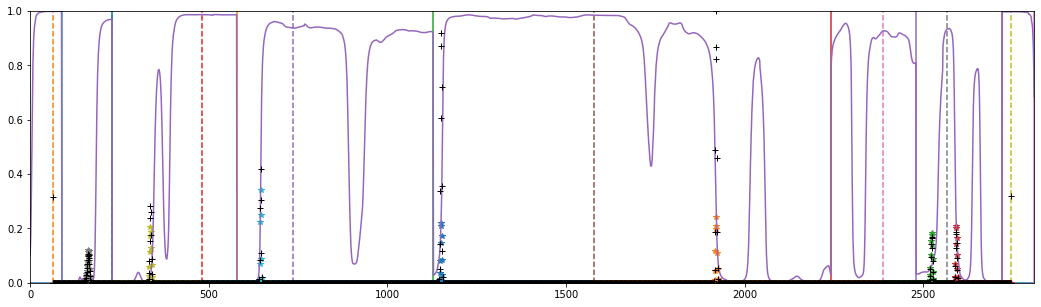

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in selected_frames_indices:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in boundary_frames_dict[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
    segment = segment.cpu().numpy()
    print(f"Min prob {i} = {np.min(segment).item()}")
    xs = np.arange(selected_frames_indices[i], 
                   selected_frames_indices[i+1])
    plt.plot(xs, segment, '*')

    
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 
plt.plot(np.arange(item[1][idx].item()), plt_arr)


loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]])
loss_arr = -loss_arr[0].detach().cpu().numpy()
plt.plot(np.arange(selected_frames_indices[0] - 1, selected_frames_indices[-1] + 1), loss_arr/np.max(loss_arr), 'k+')

plt.ylim([0, ymax])
plt.xlim([0, item[1][idx].item()])

In [40]:
loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
print(loss_prob.shape)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))

torch.Size([1, 1895, 48])


In [43]:
loss_arr[0].shape

torch.Size([1387])

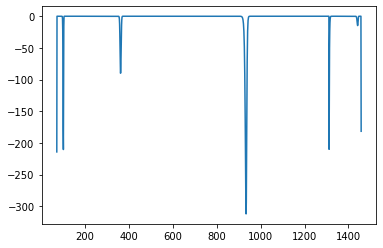

In [45]:
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr[0].detach().cpu().numpy())

In [44]:
es_loss

tensor(3.3987, device='cuda:0', dtype=torch.float64)

In [35]:
video_id_boundary_frames[cur_vidid], loaded_vidid_selected_frames[cur_vidid + ".txt"], item_1[idx]

([75, 345, 1305, 1415, 1440, 1519],
 [73, 282, 455, 1312, 1434, 1458],
 tensor(1520, device='cuda:0', dtype=torch.int32))

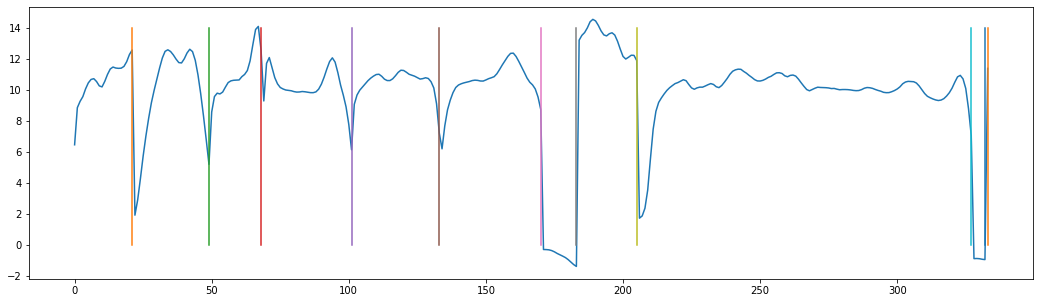

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss

In [22]:
def find_mask_for_this_class(video_len, weakly_labels_video, old_index_label_pair_list, 
                             cur_ele_searched, cur_index_searched):
    searched_label_index = np.where(cur_ele_searched == np.array(weakly_labels_video))[0]
    if len(searched_label_index) <= 1:
        mask = torch.ones(video_len)
        return mask
    else:
        start = 0
        for i, index in enumerate(searched_label_index[:-1]):
            cur_index_frame_selected = old_index_label_pair_list[index][0]
            next_index = searched_label_index[i + 1]
            next_index_frame_selected = old_index_label_pair_list[next_index][0]
            
            mid_select = (cur_index_frame_selected + next_index_frame_selected) // 2
            
            if index == cur_index_searched:
                mask = torch.zeros(video_len)
                mask[start: mid_select + 1] = 1
                return mask
            
            start = mid_select
        if searched_label_index[-1] == cur_index_searched:
            mask = torch.zeros(video_len)
            mask[start: video_len] = 1
            return mask
        else:
            import pdb
            pdb.set_trace()
            return "Error 1"
    return "Error"

In [23]:
# [2, 2, 2, 2, 3, 3, 4, 4, 3, 3, 2, 2, 2, 2]
find_mask_for_this_class(12, [2, 3, 4, 3,  2], [3, 5, 7, 8, 10], 4, 2)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])